This script analyzes the released attention sparsity trace, as described in the Observations section of our paper.

The training was performed on the WebVid-10M dataset, using a latent input size of 16×16×16. The provided trace reflects the state prior to iteration 200K. This small-scale experiment is intended to illustrate our observations and serve as motivation for the system design.

It is important to note that the sparsity pattern can vary depending on the dataset and training configuration, even though some general trends persist. For example, we observed that models trained on the Video-Gen dataset tend to exhibit more pronounced sparsity levels, along with a distinct per-layer sparsity distribution. Detailed results showing how sparsity levels evolve during training on Video-Gen can be found in the appendix of the paper.

In [50]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from collections import defaultdict
import os

In [51]:
# The directory of downloaded 'pt' files
# MAKE SURE the directory is correct !!!
DATASET_DIR = './trace'

# The prefix of the attention score and sparsity ratio files 
file_prefix='atten_sparsity_pattern_iter_'
suffix = '.pt'

all_valid_iterations = [int(iteration.split('_')[-1].split('.')[0]) for iteration in os.listdir(DATASET_DIR) if iteration.endswith('.pt')]

global_cache_attention_score = {} # {iteration: a array with shape [layer_numbers, batch_size, head_numbers, sampled_sequence_length, sequence_length]}
global_cache_sampled_query_ids = {} # {iteration: a array with shape [layer_numbers, sampled_sequence_length]}
global_cache_attention_sparsity_ratio = {} # {iteration: a array with shape [layer_numbers, head_numbers]}

# Here we need the sampled query ids because for each layers, we randomly sample queries to reduce the memory cost of attention score
# attention_score records the softmaxed attention score of the sampled queries
# sampled_query_ids records the original query ids of the sampled queries
# sparsity_ratio is the sparsity ratio of each head across different layers

def load_attention_score_and_sparsity_ratio(iteration):
    if iteration in global_cache_attention_score:
        return global_cache_attention_score[iteration], global_cache_sampled_query_ids[iteration], global_cache_attention_sparsity_ratio[iteration]
    attention_pattern_path = os.path.join(DATASET_DIR, file_prefix + str(iteration) + suffix)
    attention_pattern = torch.load(attention_pattern_path)

    attention_score = attention_pattern['attn_score_for_sampled_queries']
    sampled_query_ids = attention_pattern['query_ids_for_sampled_queries']
    attention_sparsity_ratio = attention_pattern['sparsity_ratio']

    global_cache_attention_score[iteration] = attention_score
    global_cache_attention_sparsity_ratio[iteration] = attention_sparsity_ratio
    global_cache_sampled_query_ids[iteration] = sampled_query_ids
    
    return attention_score, sampled_query_ids, attention_sparsity_ratio

In [52]:
def plot_attention_score_distribution(iteration, layer_id, head_id): 
    attention_score, _ ,_ = load_attention_score_and_sparsity_ratio(iteration)

    print(f"This figure plots the attention score distribution of layer {layer_id} head {head_id} at iteration {iteration}.")
    
    attn_score_lh = attention_score[layer_id, 0 , head_id, :, :] 

    attn_score_lh_flat = attn_score_lh.flatten() 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

    ax1.hist(attn_score_lh_flat, bins=40, density=False, color='blue', alpha=0.5)
    ax1.set_ylabel('Occurrence')
    ax1.set_xlabel('Attention Score')
    ax1.set_title(f'Attention Score Distribution\nLayer {layer_id} Head {head_id}', fontsize=10)
    ax1.set_yscale('log', base=2) 
    

    for i in range(attn_score_lh.shape[0]):
        sns.ecdfplot(attn_score_lh[i], ax=ax2,color='blue',alpha=0.5)
    ax2.set_xlabel('Sorted Index')
    ax2.set_xticks([])
    ax2.set_ylabel('Cumulative\nScore')
    ax2.set_title(f'Cumulative Distribution Function\nLayer {layer_id} Head {head_id}', fontsize=10)
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_attention_score_distribution_with_sparsity_ratio(iteration):
    _, _, sparsity_ratio = load_attention_score_and_sparsity_ratio(iteration)
    print(f'This figure plots the attention sparsity ratio distribution of all heads across different layersin iteration {iteration}.')

    fig, (ax) = plt.subplots(1, 1, figsize=(8, 1.6))
    sparsity_ratio_tra = sparsity_ratio.transpose(1,0)

    box = ax.boxplot(
        sparsity_ratio_tra, 
        patch_artist=True, 
        boxprops=dict(facecolor='#c9e6f9', color='black', linewidth=1), 
        medianprops=dict(color='black', linewidth=1.5),
        whiskerprops=dict(color='black', linewidth=1),
        capprops=dict(color='black', linewidth=1),
        flierprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=3, alpha=0.6)
    )

    ax.set_ylim(0, 1)
    ax.set_ylabel("Sparsity Level", fontsize=10)
    ax.tick_params(axis='y', labelsize=10)

    ax.set_xlabel("Attention Block Index", fontsize=10)
    ax.set_xticks(np.arange(1, sparsity_ratio_tra.shape[1]+1))
    ax.set_xticklabels([str(i) for i in range(sparsity_ratio_tra.shape[1])], fontsize=10)
    
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.6, alpha=0.4)

    plt.tight_layout()
    plt.show()

def plot_the_critical_KV_position_in_3d_space(iteration, layer_ids, head_id, sampled_query_id):

    attn_score, query_ids ,_ = load_attention_score_and_sparsity_ratio(iteration)

    print(f'This figure plots the top critical KV position for several random queries in head {head_id} across selected layers in 3D space of iteration {iteration}.')

    sample_attn_score = attn_score[layer_ids, 0, head_id, sampled_query_id, :] 


    frame, height, width = 16, 16, 16 

    fig_col = 4
    fig_row = len(layer_ids) // fig_col + 1

    fig = plt.figure(figsize=(10, 4 * fig_row)) 


    for i, layer_id in enumerate(layer_ids):

        original_query_id = query_ids[layer_id, sampled_query_id] 

        q_f, q_h, q_w = original_query_id//(frame*height), (original_query_id//width)%height, original_query_id%width

        ax = fig.add_subplot(fig_row, fig_col, i+1, projection='3d')

        this_layer_attn_score = sample_attn_score[i]  
        this_layer_attn_score_3d = this_layer_attn_score.reshape(frame, height, width) 

        normed = (this_layer_attn_score_3d - this_layer_attn_score_3d.min()) / (this_layer_attn_score_3d.max() - this_layer_attn_score_3d.min() + 1e-8)
        flat_idx = np.argsort(normed.ravel())[::-1][:200]
        mask = np.zeros_like(normed, dtype=bool)
        mask[np.unravel_index(flat_idx, normed.shape)] = True

        cmap = cm.get_cmap('Reds') 
        colors = np.zeros(mask.shape + (4,))
        colors[mask] = cmap(normed[mask]) 
        colors[..., 3] = 0.85 * mask

        ax.voxels(mask, facecolors=colors, edgecolor=None, linewidth=0.5)

        ax.scatter([q_w], [q_f], [q_h], c='green', s=100, marker='s', edgecolors='k', linewidths=0.7)

        ax.set_xlabel('W')
        ax.set_ylabel('F')
        ax.set_zlabel('H')
        ax.set_title(f'Block {layer_id}')



    plt.tight_layout()
    plt.show()


def plot_the_head_sparsity_change_with_iteration(layer_id):

    print(f'This figure plots the sparsity level of all heads across different iterations in layer {layer_id}.')
    print(f"Note that the sparsity level is sampled from a small batch of samples when making the trace so there could be a bit fluctuation, but the overall trend is still the same as we pointed.")

    sparsity_ratio_per_head = defaultdict(list)

    for iteration in sorted(all_valid_iterations):
        _, _, sparsity_ratio = load_attention_score_and_sparsity_ratio(iteration)

        for head_id in range(sparsity_ratio.shape[1]):
            sparsity_ratio_per_head[head_id].append(sparsity_ratio[layer_id, head_id])


    fig, ax = plt.subplots(figsize=(4, 2))

    for head_id, sparsity_list in sparsity_ratio_per_head.items():
        ax.plot(sorted(all_valid_iterations), sparsity_list, linewidth=0.8 ,marker='o', markersize=5, linestyle='-', label=f'Head {head_id}', alpha=0.8)

    ax.set_xlabel('Iteration')

    ax.set_ylim(0, 1)

    ax.set_ylabel('Sparsity Level')

    plt.show()





/data/tmp/ipykernel_253375/3653113269.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_pattern = torch.load(attention_pattern_path)


This figure plots the attention score distribution of layer 8 head 15 at iteration 20000.


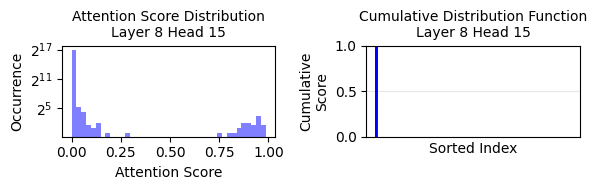

In [53]:
plot_attention_score_distribution(iteration=20000, layer_id=8, head_id=15)

/data/tmp/ipykernel_253375/3653113269.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_pattern = torch.load(attention_pattern_path)


This figure plots the attention sparsity ratio distribution of all heads across different layersin iteration 28000.


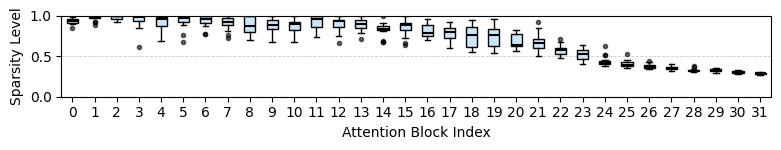

In [54]:
plot_attention_score_distribution_with_sparsity_ratio(iteration=28000)


/data/tmp/ipykernel_253375/3653113269.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_pattern = torch.load(attention_pattern_path)


This figure plots the top critical KV position for several random queries in head 15 across selected layers in 3D space of iteration 12000.


/data/tmp/ipykernel_253375/100235038.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


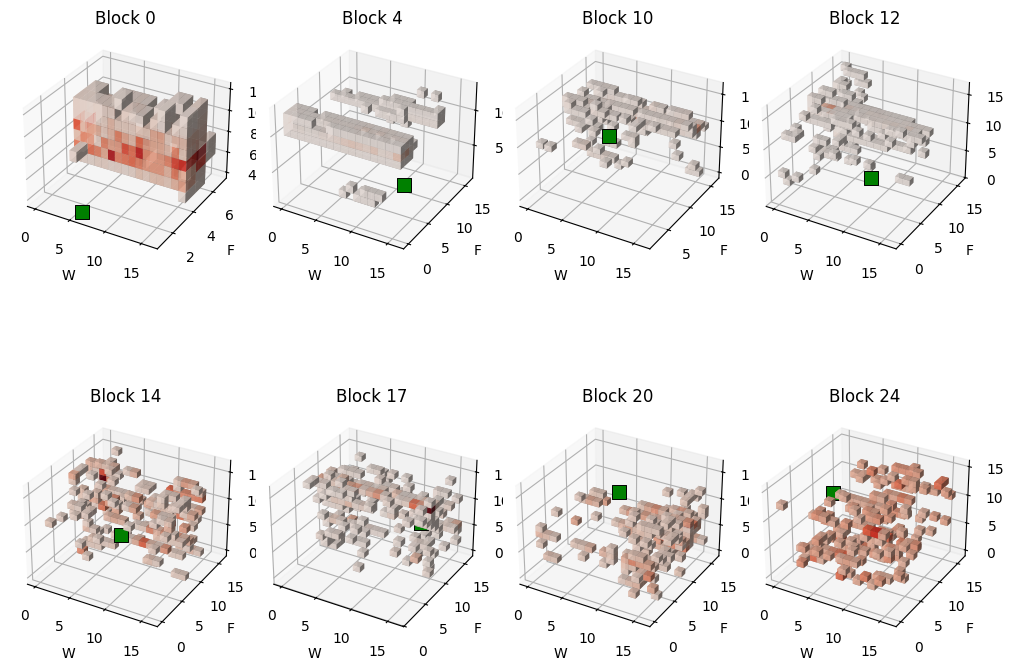

In [55]:
plot_the_critical_KV_position_in_3d_space(iteration=12000, layer_ids=[0,4,10,12, 14 ,17,20,24], head_id=15 , sampled_query_id=0)

This figure plots the sparsity level of all heads across different iterations in layer 22.
Note that the sparsity level is sampled from a small batch of samples when making the trace so there could be a bit fluctuation, but the overall trend is still the same as we pointed.


/data/tmp/ipykernel_253375/3653113269.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_pattern = torch.load(attention_pattern_path)


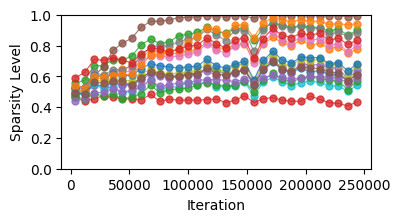

In [56]:
plot_the_head_sparsity_change_with_iteration(layer_id=22) 